In [49]:
import scipy
import statsmodels.api as sm
import statsmodels
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymatch
from pymatch.Matcher import Matcher
import sys, re, platform, glob
from tqdm.autonotebook import tqdm

tqdm.pandas()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Fixed seed for reproducibility
np.random.seed(11072021)

print(f"Python version: {sys.version}")
print(f"OS version: {platform.platform()}")
print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")
print(f"scipy version: {scipy.__version__}")
print(f"statsmodels version: {statsmodels.__version__}")

Python version: 3.7.5 (v3.7.5:5c02a39a0b, Oct 14 2019, 18:49:57) 
[Clang 6.0 (clang-600.0.57)]
OS version: Darwin-20.2.0-x86_64-i386-64bit
pandas version: 1.3.0
numpy version: 1.21.0
scipy version: 1.7.0
statsmodels version: 0.12.2


## Analysis

### Loading VAERS data

Note: for legal reasons, we cannot reproduce the raw VAERS data in Github. However, you can download the VAERS data set
from [HHS](https://vaers.hhs.gov).

In [50]:
%%time

path = "../data/" # use your path
vaccine_files = glob.glob(path + "*VAERSVAX.csv")

vax_frames = []

for filename in tqdm(vaccine_files):
    df = pd.read_csv(filename, index_col=None, header=0, encoding="latin")
    vax_frames.append(df)

vax = pd.concat(vax_frames, axis=0, ignore_index=True)[["VAERS_ID", "VAX_TYPE", "VAX_DOSE_SERIES", "VAX_NAME"]]

  0%|          | 0/22 [00:00<?, ?it/s]

CPU times: user 1.31 s, sys: 550 ms, total: 1.86 s
Wall time: 2.3 s


In [51]:
%%time

recipient_files = glob.glob(path + "*VAERSDATA.csv")

recipient_frames = []

for filename in tqdm(recipient_files):
    df = pd.read_csv(filename, index_col=None, header=0, encoding="latin")
    recipient_frames.append(df)

recipients = pd.concat(recipient_frames, axis=0, ignore_index=True)


  0%|          | 0/22 [00:00<?, ?it/s]

CPU times: user 9.71 s, sys: 3.62 s, total: 13.3 s
Wall time: 15.4 s


In [52]:
%%time

symptoms_files = glob.glob(path + "*VAERSSYMPTOMS.csv")

symptoms_frames = []

for filename in tqdm(symptoms_files):
    df = pd.read_csv(filename, index_col=None, header=0)
    symptoms_frames.append(df)

symptoms = pd.melt(pd.concat(symptoms_frames, axis=0, ignore_index=True)[["VAERS_ID", "SYMPTOM1", "SYMPTOM2", "SYMPTOM3", "SYMPTOM4", "SYMPTOM5"]],
               id_vars="VAERS_ID",
               value_vars=(f"SYMPTOM{i}" for i in range(1, 6))).drop("variable", axis=1)

symptoms.columns = ("VAERS_ID", "SYMPTOM")
symptoms = symptoms.dropna()

  0%|          | 0/22 [00:00<?, ?it/s]

CPU times: user 2.34 s, sys: 656 ms, total: 3 s
Wall time: 3.33 s


### Merge data frames

In [53]:
%%time

data = vax.merge(recipients).merge(symptoms)

print(f"Imported {data.VAERS_ID.unique().shape[0]:,} reports.")


Imported 1,018,240 reports.
CPU times: user 6.32 s, sys: 4.42 s, total: 10.7 s
Wall time: 12.1 s


### Filtering reports

#### Filtering unknown ages and genders

In [54]:
v_0 = data.VAERS_ID.unique().shape[0]
data = data.dropna(subset = ["AGE_YRS"])
v_1 = data.VAERS_ID.unique().shape[0]
data = data[data.SEX.isin(["M", "F"])]
v_2 = data.VAERS_ID.unique().shape[0]

print(f"Discarded {v_1 - v_0:,} reports for unknown age.")
print(f"Discarded {v_2 - v_1:,} reports for unreported or unknown gender.")
print(f"n={v_2:,}")

Discarded -140,270 reports for unknown age.
Discarded -18,974 reports for unreported or unknown gender.
n=858,996



#### Filter unknown vaccines and unknown COVID vaccines

In [55]:
v_0 = data.VAERS_ID.unique().shape[0]
data = data[data.VAX_TYPE != "UNK"]
v_1 = data.VAERS_ID.unique().shape[0]
data = data[data.VAX_NAME != "COVID19 (COVID19 (UNKNOWN))"]
v_2 = data.VAERS_ID.unique().shape[0]

print(f"Discarded {v_1 - v_0:,} reports for unknown vaccine type.")
print(f"Discarded {v_2 - v_1:,} reports for unknown COVID-19 vaccine subclass.")
print(f"n={v_2:,}")

Discarded -4,660 reports for unknown vaccine type.
Discarded -744 reports for unknown COVID-19 vaccine subclass.
n=853,592


### Classifying cases and controls

In [56]:
anaphylactic_presentations = [
    "Anaphylactic shock",
    "Anaphylactic reaction",
    "Anaphylactoid shock",
    "Anaphylactoid reaction"
]

In [57]:
data["IS_ANAPHYLACTIC"] = data.SYMPTOM.isin(anaphylactic_presentations)

In [58]:
data.VAERS_ID.unique().shape[0]

853592

In [59]:
data = data.drop("IS_ANAPHYLACTIC", axis=1).merge(data.groupby("VAERS_ID")["IS_ANAPHYLACTIC"].max(), right_index=True, left_on="VAERS_ID").groupby("VAERS_ID").first()

In [60]:
%%time

print(f"{data[data.IS_ANAPHYLACTIC == True].shape[0]} cases identified.")
print(f"{data[data.IS_ANAPHYLACTIC == False].shape[0]} possible controls identified.")

2665 cases identified.
850927 possible controls identified.
CPU times: user 686 ms, sys: 228 ms, total: 914 ms
Wall time: 914 ms


### Classifying cases and controls by mRNA status

In [61]:
data["IS_MRNA_VACCINE"] = data.VAX_NAME.isin(["COVID19 (COVID19 (PFIZER-BIONTECH))",
                                              "COVID19 (COVID19 (MODERNA))"])

In [62]:
pd.crosstab(data.IS_MRNA_VACCINE, data.IS_ANAPHYLACTIC).sort_index(ascending=False).sort_index(axis=1, ascending=False)

IS_ANAPHYLACTIC,True,False
IS_MRNA_VACCINE,,
True,1352,340427
False,1313,510500


### Crude odds ratio (before matching)

In [63]:
contingency_table = sm.stats.Table2x2(pd.crosstab(data.IS_MRNA_VACCINE, data.IS_ANAPHYLACTIC).rename(columns={0: False, 1: True}).sort_index(ascending=False).sort_index(axis=1, ascending=False))

print(f"Crude OR for anaphylaxis: {contingency_table.oddsratio:.3f} @ p = {contingency_table.oddsratio_pvalue()}")
print(f"CI: {contingency_table.oddsratio_confint()[0]:.3f} –– {contingency_table.oddsratio_confint()[1]:.3f}")

Crude OR for anaphylaxis: 1.544 @ p = 4.325282181637507e-29
CI: 1.431 –– 1.666


### Matching

In [66]:
data = data.reset_index()
cases = data[data.IS_ANAPHYLACTIC == True][["VAERS_ID", "AGE_YRS", "SEX", "IS_ANAPHYLACTIC", "IS_MRNA_VACCINE"]]
controls = data[data.IS_ANAPHYLACTIC == False][["VAERS_ID", "AGE_YRS", "SEX", "IS_ANAPHYLACTIC", "IS_MRNA_VACCINE"]]

In [67]:
m = Matcher(cases, controls, yvar="IS_ANAPHYLACTIC", exclude=["VAERS_ID", "IS_MRNA_VACCINE"])

Formula:
IS_ANAPHYLACTIC ~ AGE_YRS+SEX
n majority: 850927
n minority: 2665


In [68]:
%%time

m.fit_scores(balance=True, nmodels=100)

Fitting Models on Balanced Samples: 100\100
Average Accuracy: 55.51%
CPU times: user 35.5 s, sys: 7.37 s, total: 42.9 s
Wall time: 11.6 s


In [69]:
%%time

m.predict_scores()

CPU times: user 7.02 s, sys: 1.28 s, total: 8.3 s
Wall time: 2.09 s


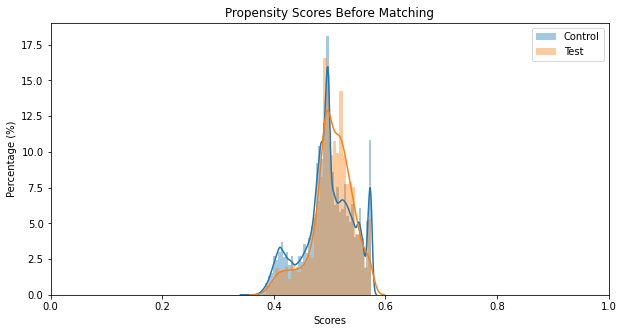

In [70]:
m.plot_scores()
plt.savefig("../writeup/propensity_scores.pdf")

In [71]:
%%time

m.match(method="random", nmatches=3)

CPU times: user 12.4 s, sys: 147 ms, total: 12.6 s
Wall time: 12.6 s


In [72]:
%%time

m.record_frequency()

CPU times: user 8.9 ms, sys: 6.15 ms, total: 15.1 ms
Wall time: 13.9 ms


,freq,n_records
0,1,9748
1,2,41
2,3,1


In [73]:
%%time

m.assign_weight_vector()

CPU times: user 12.5 ms, sys: 3.06 ms, total: 15.5 ms
Wall time: 14.4 ms


In [74]:
m.matched_data.shape

(9833, 9)

In [75]:
df = m.matched_data.merge(data[["VAERS_ID", "IS_MRNA_VACCINE"]]).groupby(["record_id", "match_id"]).first()

In [76]:
df = df.reset_index()

In [77]:
matched_df = df.merge(data[["VAERS_ID", "ALLERGIES"]]).groupby("VAERS_ID").first()


### Anaphylaxis OR for all COVID-19 vaccines

In [78]:
pd.crosstab(matched_df.IS_MRNA_VACCINE, matched_df.IS_ANAPHYLACTIC).rename(columns={0: False, 1: True}).sort_index(ascending=False).sort_index(axis=1, ascending=False)

IS_ANAPHYLACTIC,True,False
IS_MRNA_VACCINE,,
True,1352,3116
False,1313,4009


In [79]:
contingency_table = sm.stats.Table2x2(pd.crosstab(matched_df.IS_MRNA_VACCINE, matched_df.IS_ANAPHYLACTIC).rename(columns={0: False, 1: True}).sort_index(ascending=False).sort_index(axis=1, ascending=False))

print(f"OR for anaphylaxis: {contingency_table.oddsratio:.3f} @ p = {contingency_table.oddsratio_pvalue()}")
print(f"CI: {contingency_table.oddsratio_confint()[0]:.3f} –– {contingency_table.oddsratio_confint()[1]:.3f}")

OR for anaphylaxis: 1.325 @ p = 6.429022818129216e-10
CI: 1.212 –– 1.448


### Odds ratios by gender

#### Crude

In [80]:
odds_ratios_by_gender_crude = pd.DataFrame(columns = ("ROR", "p_value", "95CI_lower", "95CI_upper"))

for gender in tqdm(data.SEX.unique()):
    df = data[data.SEX == gender]
    xt = pd.crosstab(df.IS_MRNA_VACCINE, df.IS_ANAPHYLACTIC).rename(columns={0: False, 1: True}).sort_index(ascending=False).sort_index(axis=1, ascending=False)
    try:
        if xt[True][True] > 10:
            ct = sm.stats.Table2x2(xt)
            odds_ratios_by_gender_crude.loc[gender, "ROR"] = ct.oddsratio
            odds_ratios_by_gender_crude.loc[gender, "p_value"] = ct.oddsratio_pvalue()
            odds_ratios_by_gender_crude.loc[gender, "95CI_lower"] = ct.oddsratio_confint()[0]
            odds_ratios_by_gender_crude.loc[gender, "95CI_upper"] = ct.oddsratio_confint()[1]
            odds_ratios_by_gender_crude.loc[gender, "a"] = xt[True][True]
            odds_ratios_by_gender_crude.loc[gender, "b"] = xt[False][True]
            odds_ratios_by_gender_crude.loc[gender, "c"] = xt[True][False]
            odds_ratios_by_gender_crude.loc[gender, "d"] = xt[False][False]
    except KeyError:
        continue

  0%|          | 0/2 [00:00<?, ?it/s]

In [81]:
odds_ratios_by_gender_crude

,ROR,p_value,95CI_lower,95CI_upper,a,b,c,d
F,1.848804,0.0,1.688533,2.024288,1134.0,248823.0,799.0,324127.0
M,0.862903,0.068443,0.736339,1.011221,218.0,91604.0,514.0,186373.0


In [82]:
stratified_contingency_of_genders_crude = list()

for stratum in odds_ratios_by_gender_crude.index:
    stratified_contingency_of_genders_crude.append([[odds_ratios_by_gender_crude.loc[stratum, "a"], odds_ratios_by_gender_crude.loc[stratum, "b"]], [odds_ratios_by_gender_crude.loc[stratum, "c"], odds_ratios_by_gender_crude.loc[stratum, "d"]]])

st = sm.stats.StratifiedTable(stratified_contingency_of_genders_crude)

print(st.summary())

                   Estimate   LCB    UCB 
-----------------------------------------
Pooled odds           1.525   1.412 1.647
Pooled log odds       0.422   0.345 0.499
Pooled risk ratio     1.523              
                                         
                 Statistic P-value 
-----------------------------------
Test of OR=1       115.175   0.000 
Test constant OR    68.230   0.000 
                         
-------------------------
Number of tables      2  
Min n            278709  
Max n            574883  
Avg n            426796  
Total n          853592  
-------------------------


#### Adjusted for age and gender

In [83]:
odds_ratios_by_gender = pd.DataFrame(columns = ("ROR", "p_value", "95CI_lower", "95CI_upper"))

for gender in tqdm(matched_df.SEX.unique()):
    df = matched_df[matched_df.SEX == gender]
    xt = pd.crosstab(df.IS_MRNA_VACCINE, df.IS_ANAPHYLACTIC).rename(columns={0: False, 1: True}).sort_index(ascending=False).sort_index(axis=1, ascending=False)
    try:
        if xt[True][True] > 10:
            ct = sm.stats.Table2x2(xt)
            odds_ratios_by_gender.loc[gender, "ROR"] = ct.oddsratio
            odds_ratios_by_gender.loc[gender, "p_value"] = ct.oddsratio_pvalue()
            odds_ratios_by_gender.loc[gender, "95CI_lower"] = ct.oddsratio_confint()[0]
            odds_ratios_by_gender.loc[gender, "95CI_upper"] = ct.oddsratio_confint()[1]
            odds_ratios_by_gender.loc[gender, "a"] = xt[True][True]
            odds_ratios_by_gender.loc[gender, "b"] = xt[False][True]
            odds_ratios_by_gender.loc[gender, "c"] = xt[True][False]
            odds_ratios_by_gender.loc[gender, "d"] = xt[False][False]
    except KeyError:
        continue

  0%|          | 0/2 [00:00<?, ?it/s]

In [84]:
odds_ratios_by_gender

,ROR,p_value,95CI_lower,95CI_upper,a,b,c,d
F,1.461922,0.0,1.315891,1.62416,1134.0,2629.0,799.0,2708.0
M,1.133031,0.196593,0.937376,1.369524,218.0,487.0,514.0,1301.0


In [85]:
stratified_contingency_of_genders = list()

for stratum in odds_ratios_by_gender.index:
    stratified_contingency_of_genders.append([[odds_ratios_by_gender.loc[stratum, "a"], odds_ratios_by_gender.loc[stratum, "b"]], [odds_ratios_by_gender.loc[stratum, "c"], odds_ratios_by_gender.loc[stratum, "d"]]])

st = sm.stats.StratifiedTable(stratified_contingency_of_genders)

print(st.summary())

                   Estimate   LCB    UCB 
-----------------------------------------
Pooled odds           1.378   1.257 1.510
Pooled log odds       0.320   0.229 0.412
Pooled risk ratio     1.263              
                                         
                 Statistic P-value 
-----------------------------------
Test of OR=1        46.868   0.000 
Test constant OR     5.314   0.021 
                       
-----------------------
Number of tables    2  
Min n            2520  
Max n            7270  
Avg n            4895  
Total n          9790  
-----------------------


### Odds ratios by age band

#### Crude

In [86]:
data["age_band"] = pd.cut(data.AGE_YRS,
                          bins=(0, 18, 25, 35, 45, 55, 65, 75, 85, 95, 120),
                          labels=("<18", "19-25", "26-35", "36-45", "46-55", "56-65", "66-75", "76-85", "86-95", ">95"),
                          right=True)

data = data.dropna(subset = ["age_band"])

matched_df["age_band"] = pd.cut(matched_df.AGE_YRS,
                          bins=(0, 18, 25, 35, 45, 55, 65, 75, 85, 95, 120),
                          labels=("<18", "19-25", "26-35", "36-45", "46-55", "56-65", "66-75", "76-85", "86-95", ">95"),
                          right=True)

In [87]:
odds_ratios_by_age_band_crude = pd.DataFrame(columns = ("ROR", "p_value", "95CI_lower", "95CI_upper", "a", "b", "c", "d"))

In [88]:
for age_band in tqdm(data.age_band.unique()):
    try:
        df = data[data["age_band"] == age_band]
        xt = pd.crosstab(df.IS_MRNA_VACCINE, df.IS_ANAPHYLACTIC).rename(columns={0: False, 1: True}).sort_index(ascending=False).sort_index(axis=1, ascending=False)
        ct = sm.stats.Table2x2(xt)
        odds_ratios_by_age_band_crude.loc[age_band, "ROR"] = ct.oddsratio
        odds_ratios_by_age_band_crude.loc[age_band, "p_value"] = ct.oddsratio_pvalue()
        odds_ratios_by_age_band_crude.loc[age_band, "95CI_lower"] = ct.oddsratio_confint()[0]
        odds_ratios_by_age_band_crude.loc[age_band, "95CI_upper"] = ct.oddsratio_confint()[1]
        odds_ratios_by_age_band_crude.loc[age_band, "a"] = xt[True][True]
        odds_ratios_by_age_band_crude.loc[age_band, "b"] = xt[False][True]
        odds_ratios_by_age_band_crude.loc[age_band, "c"] = xt[True][False]
        odds_ratios_by_age_band_crude.loc[age_band, "d"] = xt[False][False]

    except ValueError:
        continue

  0%|          | 0/10 [00:00<?, ?it/s]

In [89]:
odds_ratios_by_age_band_crude

,ROR,p_value,95CI_lower,95CI_upper,a,b,c,d
<18,1.21933,0.197081,0.90212,1.648079,46,14017,550,204353
26-35,1.324702,0.009577,1.07086,1.638716,234,52997,134,40203
46-55,1.880795,0.0,1.530185,2.31174,304,58856,129,46973
36-45,1.162617,0.115103,0.963918,1.402275,314,61329,169,38376
19-25,1.151778,0.341865,0.860641,1.541401,80,21180,105,32018
76-85,1.658209,0.041459,1.019775,2.696337,41,19491,27,21284
66-75,1.782774,0.00007,1.340539,2.3709,116,47316,80,58175
56-65,2.059736,0.0,1.639189,2.588177,213,58669,113,64109
86-95,1.007716,0.991974,0.225426,4.504753,4,5962,3,4506


In [90]:
stratified_contingency_of_age_bands_crude = list()

for stratum in odds_ratios_by_age_band_crude.index:
    stratified_contingency_of_age_bands_crude.append([[odds_ratios_by_age_band_crude.loc[stratum, "a"], odds_ratios_by_age_band_crude.loc[stratum, "b"]], [odds_ratios_by_age_band_crude.loc[stratum, "c"], odds_ratios_by_age_band_crude.loc[stratum, "d"]]])

st = sm.stats.StratifiedTable(stratified_contingency_of_age_bands_crude)

print(st.summary())


                   Estimate   LCB    UCB 
-----------------------------------------
Pooled odds           1.491   1.368 1.625
Pooled log odds       0.399   0.313 0.486
Pooled risk ratio     1.489              
                                         
                 Statistic P-value 
-----------------------------------
Test of OR=1        83.545   0.000 
Test constant OR    27.351   0.001 
                         
-------------------------
Number of tables      9  
Min n             10475  
Max n            218966  
Avg n             94720  
Total n          852476  
-------------------------


#### Adjusted for age and gender

In [91]:
odds_ratios_by_age_band = pd.DataFrame(columns = ("ROR", "p_value", "95CI_lower", "95CI_upper", "a", "b", "c", "d"))

In [92]:
for age_band in tqdm(matched_df.age_band.unique()):
    try:
        df = matched_df[matched_df.age_band == age_band]
        xt = pd.crosstab(df.IS_MRNA_VACCINE, df.IS_ANAPHYLACTIC).rename(columns={0: False, 1: True}).sort_index(ascending=False).sort_index(axis=1, ascending=False)
        ct = sm.stats.Table2x2(xt)
        odds_ratios_by_age_band.loc[age_band, "ROR"] = ct.oddsratio
        odds_ratios_by_age_band.loc[age_band, "p_value"] = ct.oddsratio_pvalue()
        odds_ratios_by_age_band.loc[age_band, "95CI_lower"] = ct.oddsratio_confint()[0]
        odds_ratios_by_age_band.loc[age_band, "95CI_upper"] = ct.oddsratio_confint()[1]
        odds_ratios_by_age_band.loc[age_band, "a"] = xt[True][True]
        odds_ratios_by_age_band.loc[age_band, "b"] = xt[False][True]
        odds_ratios_by_age_band.loc[age_band, "c"] = xt[True][False]
        odds_ratios_by_age_band.loc[age_band, "d"] = xt[False][False]

    except ValueError:
        continue

  0%|          | 0/11 [00:00<?, ?it/s]

In [93]:
odds_ratios_by_age_band

,ROR,p_value,95CI_lower,95CI_upper,a,b,c,d
36-45,0.991977,0.942744,0.796214,1.235871,314,826,169,441
46-55,1.738877,0.000005,1.372091,2.203713,304,660,129,487
26-35,1.374722,0.012209,1.071809,1.763243,234,517,134,407
<18,1.405475,0.071772,0.970316,2.035791,46,87,550,1462
19-25,1.034586,0.847263,0.731988,1.462277,80,190,105,258
66-75,1.927056,0.000108,1.382528,2.686054,116,231,80,307
56-65,1.945114,0.000001,1.498275,2.525216,213,470,113,485
76-85,1.790706,0.038018,1.032732,3.104994,41,106,27,125
86-95,1.679012,0.520313,0.345866,8.150786,4,27,3,34


In [94]:
stratified_contingency_of_age_bands = list()

for stratum in odds_ratios_by_age_band.index:
    stratified_contingency_of_age_bands.append([[odds_ratios_by_age_band.loc[stratum, "a"], odds_ratios_by_age_band.loc[stratum, "b"]], [odds_ratios_by_age_band.loc[stratum, "c"], odds_ratios_by_age_band.loc[stratum, "d"]]])

st = sm.stats.StratifiedTable(stratified_contingency_of_age_bands)

print(st.summary())

                   Estimate   LCB    UCB 
-----------------------------------------
Pooled odds           1.441   1.302 1.593
Pooled log odds       0.365   0.264 0.466
Pooled risk ratio     1.306              
                                         
                 Statistic P-value 
-----------------------------------
Test of OR=1        50.914   0.000 
Test constant OR    25.934   0.001 
                       
-----------------------
Number of tables    9  
Min n              68  
Max n            2145  
Avg n            1087  
Total n          9782  
-----------------------


#### Plot

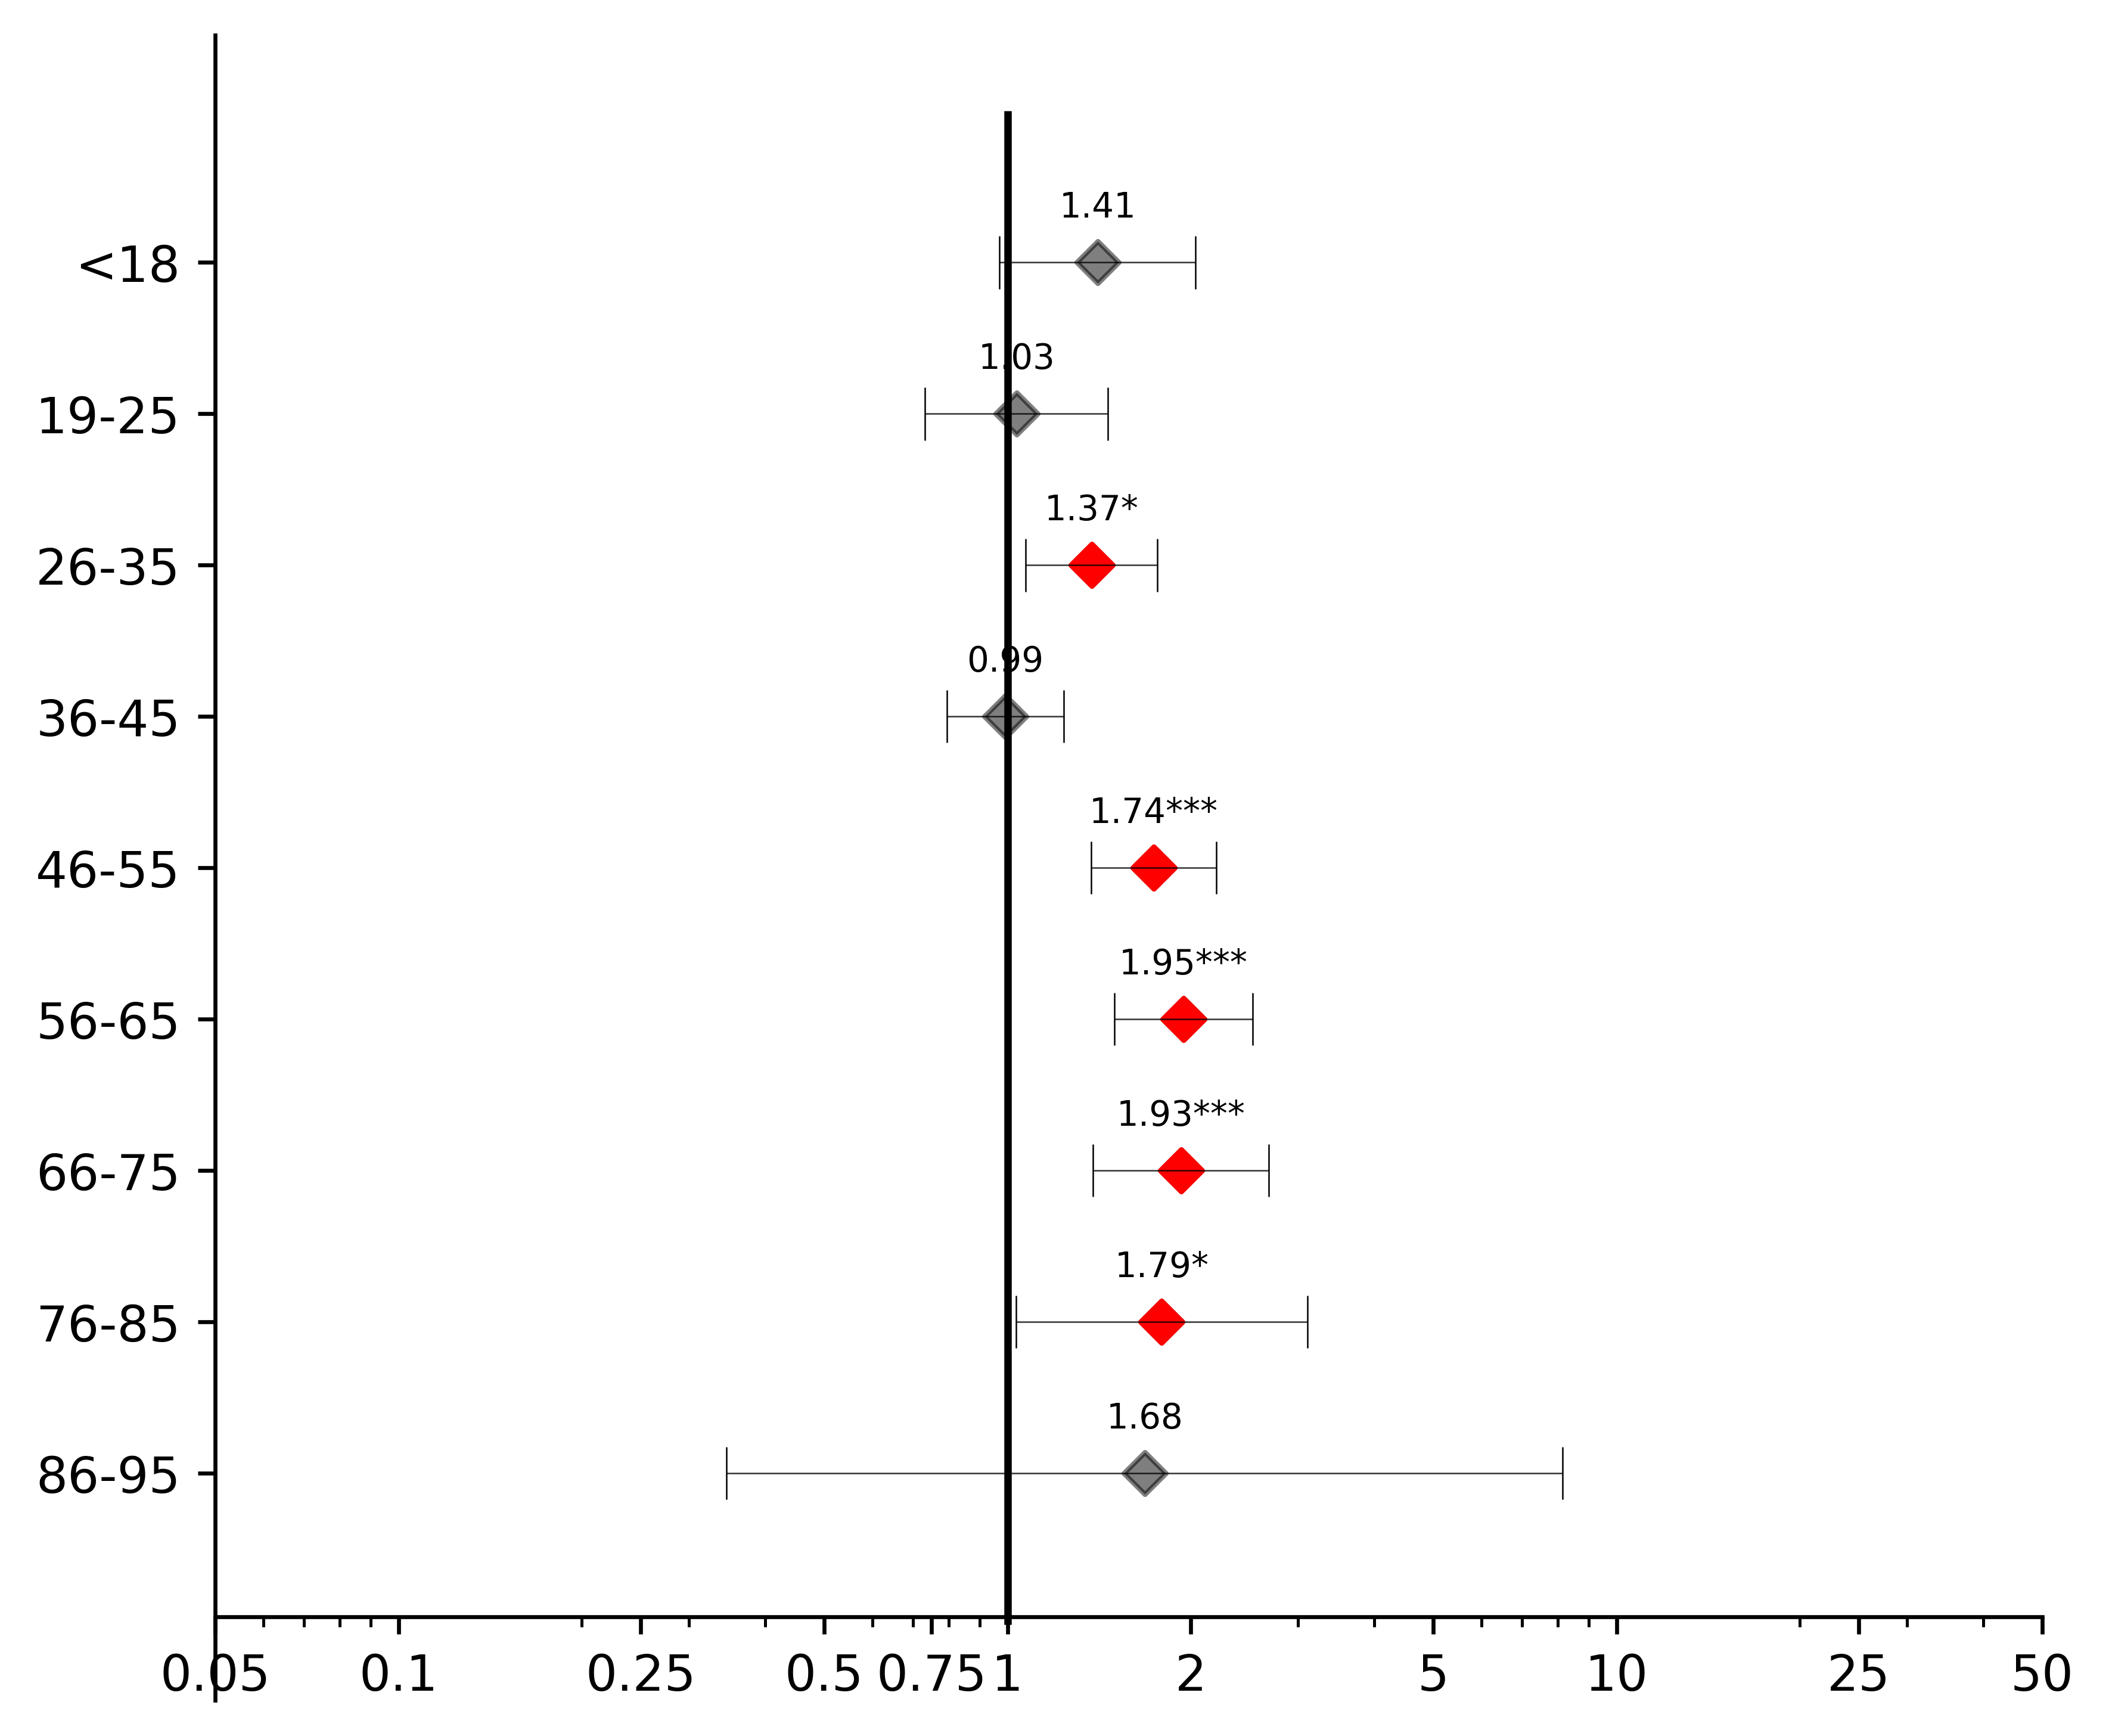

In [95]:
WHISKER:float = 0.175

fig, ax = plt.subplots(figsize=(6, 5), dpi=600)

odds_ratios_by_age_band.index = pd.CategoricalIndex(odds_ratios_by_age_band.index,
                                                    categories = ["<18", "19-25", "26-35", "36-45", "46-55", "56-65", "66-75", "76-85", "86-95"],
                                                    ordered=True)

odds_ratios_by_age_band = odds_ratios_by_age_band.sort_index(ascending=False)

ax.scatter(odds_ratios_by_age_band.ROR, odds_ratios_by_age_band.index, marker="D", color="k", alpha=0.5)
ax.scatter(odds_ratios_by_age_band[odds_ratios_by_age_band.p_value < 0.05].ROR, odds_ratios_by_age_band[odds_ratios_by_age_band.p_value < 0.05].index, marker="D", color="r", alpha=1.0)

ax.vlines(x=1, ymin=-1, ymax=len(odds_ratios_by_age_band.index), colors="k")

for idx, val in enumerate(odds_ratios_by_age_band.index):
    ax.hlines(y=idx, xmin=odds_ratios_by_age_band.loc[val, "95CI_lower"], xmax=odds_ratios_by_age_band.loc[val, "95CI_upper"], color="k", lw=0.3, alpha=0.8)
    pvalue_marker = "***" if odds_ratios_by_age_band.loc[val, "p_value"] < 0.001 else ("**" if odds_ratios_by_age_band.loc[val, "p_value"] < 0.005 else ("*" if odds_ratios_by_age_band.loc[val, "p_value"] < 0.05 else ""))
    ax.text(y = idx + 0.3, x = odds_ratios_by_age_band.loc[val, "ROR"], s = f"{odds_ratios_by_age_band.loc[val, 'ROR']:.2f}{pvalue_marker}", horizontalalignment="center", fontsize="x-small")
    ax.vlines(x=odds_ratios_by_age_band.loc[val, "95CI_lower"], ymin=idx-WHISKER, ymax=idx+WHISKER, color="k", lw=0.3)
    ax.vlines(x=odds_ratios_by_age_band.loc[val, "95CI_upper"], ymin=idx-WHISKER, ymax=idx+WHISKER, color="k", lw=0.3)

ax.set_xscale("log")
#ax.set_xlim(4e-2, 4e0)

ax.spines.left.set_position(("axes", 0.0))
ax.spines.right.set_color("none")
ax.spines.bottom.set_position(("axes", 0.05))
ax.spines.top.set_color("none")
ax.xaxis.set_ticks_position("bottom")
ax.yaxis.set_ticks_position("left")

ax.set_xticks([0.05, 0.1, 0.25, 0.5, 0.75, 1, 2, 5, 10, 25, 50])
ax.set_xticklabels([0.05, 0.10, 0.25, 0.5, 0.75, 1, 2, 5, 10, 25, 50])

plt.tight_layout()
plt.savefig("../writeup/forest_plot_of_anaphylaxis_by_age.pdf")

plt.show()


### Odds ratios by known allergies

In [96]:
extractors:dict = {
    "Opioids": r".*(cod(e)?(i|o)n(e)?|orphine|fenta|CDN|Demerol|contin|(o|i)cet|dilaud|methad|talwin|pentazocin(e)?).*",
    "Latex": r".*latex.*",
    "Macrolide and amino-\nglycoside antibiotics": r".*(mycin|Zithro|Z-pack|macroli|neosporin).*",
    "Tetracycline\nantibiotics": r".*(cycline).*",
    "Sulfas": r".*(sulf(a|ur|onam)|bactrim|sulfamet|SMX).*",
    "Beta-lactam\nantbiotics": r".*(pen(n)?(i|e)|keflex|ce(f|ph)a|cill(l)?in|augmentin|PCN|amox|roce(f|ph)).*",
    "Fluoroquinolone\nantibiotics": r".*(floxacin|cipro|quinolo).*",
    "HCTZ": ".*(h(ctz|ydrochlorothiazide)).*",
    "Glycols": r".*(PEG|(polyeth|prop)ylene glycol).*",
    "Local anaesthetics": r".*(caine).*",
    "Known vaccine\nhypersensitivities": r".*(va(x|cc)|bexsero|mmr|tetanus|tdap|dtap|prevnar|pneumovax|shingles|hepatitis).*",
    "Fish and/or\nseafood": r".*(fish|sea(\s)?food|mussels|crab|scallops).*",
    "Insect stings": r".*(bee|wasp|sting).*",
    "Eggs": r".*(egg).*",
    "NSAIDs": r".*(ibuprofen|motrin|advil|acetamino|nsaid|coxib|celebrex|APAP|as(a|pirin)|voltaren|naprox|to(d|r)olac|vioxx|mobic).*",
    "Peanuts and\ntree nuts": r".*(nut).*"
}

#### Crude

In [97]:
odds_ratios_by_preexisting_allergy_crude = pd.DataFrame(columns = ("ROR", "p_value", "95CI_lower", "95CI_upper"))

all_allergics = data[["VAERS_ID", "IS_ANAPHYLACTIC", "IS_MRNA_VACCINE", "ALLERGIES"]].groupby("VAERS_ID").first().dropna()

for key in tqdm(extractors):
    df = all_allergics[all_allergics.ALLERGIES.str.match(re.compile(extractors[key], re.IGNORECASE))]
    xt = pd.crosstab(df.IS_MRNA_VACCINE, df.IS_ANAPHYLACTIC).rename(columns={0: False, 1: True}).sort_index(ascending=False).sort_index(axis=1, ascending=False)
    try:
        ct = sm.stats.Table2x2(xt)
        odds_ratios_by_preexisting_allergy_crude.loc[key, "ROR"] = ct.oddsratio
        odds_ratios_by_preexisting_allergy_crude.loc[key, "p_value"] = ct.oddsratio_pvalue()
        odds_ratios_by_preexisting_allergy_crude.loc[key, "95CI_lower"] = ct.oddsratio_confint()[0]
        odds_ratios_by_preexisting_allergy_crude.loc[key, "95CI_upper"] = ct.oddsratio_confint()[1]
        odds_ratios_by_preexisting_allergy_crude.loc[key, "a"] = xt[True][True]
        odds_ratios_by_preexisting_allergy_crude.loc[key, "b"] = xt[False][True]
        odds_ratios_by_preexisting_allergy_crude.loc[key, "c"] = xt[True][False]
        odds_ratios_by_preexisting_allergy_crude.loc[key, "d"] = xt[False][False]

    except ValueError:
        continue

  0%|          | 0/16 [00:00<?, ?it/s]

In [98]:
stratified_contingency_by_preexisting_allergy_crude = list()

for stratum in odds_ratios_by_preexisting_allergy_crude.index:
    stratified_contingency_by_preexisting_allergy_crude.append([[odds_ratios_by_preexisting_allergy_crude.loc[stratum, "a"], odds_ratios_by_preexisting_allergy_crude.loc[stratum, "b"]], [odds_ratios_by_preexisting_allergy_crude.loc[stratum, "c"], odds_ratios_by_preexisting_allergy_crude.loc[stratum, "d"]]])

st = sm.stats.StratifiedTable(stratified_contingency_by_preexisting_allergy_crude)

print(st.summary())

                   Estimate   LCB    UCB 
-----------------------------------------
Pooled odds           1.600   1.373 1.865
Pooled log odds       0.470   0.317 0.624
Pooled risk ratio     1.595              
                                         
                 Statistic P-value 
-----------------------------------
Test of OR=1        36.691   0.000 
Test constant OR    20.378   0.158 
                         
-------------------------
Number of tables     16  
Min n               225  
Max n             50519  
Avg n             11106  
Total n          177697  
-------------------------


#### Adjusted for age and gender

In [99]:
odds_ratios_by_preexisting_allergy = pd.DataFrame(columns = ("ROR", "p_value", "95CI_lower", "95CI_upper"))

In [100]:
all_allergics = matched_df[["IS_ANAPHYLACTIC", "IS_MRNA_VACCINE", "ALLERGIES"]].dropna()

for key in tqdm(extractors):
    df = all_allergics[all_allergics.ALLERGIES.str.match(re.compile(extractors[key], re.IGNORECASE))]
    xt = pd.crosstab(df.IS_MRNA_VACCINE, df.IS_ANAPHYLACTIC).rename(columns={0: False, 1: True}).sort_index(ascending=False).sort_index(axis=1, ascending=False)
    try:
        ct = sm.stats.Table2x2(xt)
        odds_ratios_by_preexisting_allergy.loc[key, "ROR"] = ct.oddsratio
        odds_ratios_by_preexisting_allergy.loc[key, "p_value"] = ct.oddsratio_pvalue()
        odds_ratios_by_preexisting_allergy.loc[key, "95CI_lower"] = ct.oddsratio_confint()[0]
        odds_ratios_by_preexisting_allergy.loc[key, "95CI_upper"] = ct.oddsratio_confint()[1]
        odds_ratios_by_preexisting_allergy.loc[key, "a"] = xt[True][True]
        odds_ratios_by_preexisting_allergy.loc[key, "b"] = xt[False][True]
        odds_ratios_by_preexisting_allergy.loc[key, "c"] = xt[True][False]
        odds_ratios_by_preexisting_allergy.loc[key, "d"] = xt[False][False]

    except ValueError:
        continue

  0%|          | 0/16 [00:00<?, ?it/s]

In [101]:

stratified_contingency_by_preexisting_allergy = list()

for stratum in odds_ratios_by_preexisting_allergy.index:
    stratified_contingency_by_preexisting_allergy.append([[odds_ratios_by_preexisting_allergy.loc[stratum, "a"], odds_ratios_by_preexisting_allergy.loc[stratum, "b"]], [odds_ratios_by_preexisting_allergy.loc[stratum, "c"], odds_ratios_by_preexisting_allergy.loc[stratum, "d"]]])

st = sm.stats.StratifiedTable(stratified_contingency_by_preexisting_allergy)

print(st.summary())


                   Estimate   LCB    UCB 
-----------------------------------------
Pooled odds           1.367   1.122 1.666
Pooled log odds       0.313   0.115 0.510
Pooled risk ratio     1.200              
                                         
                 Statistic P-value 
-----------------------------------
Test of OR=1         9.666   0.002 
Test constant OR    16.795   0.209 
                       
-----------------------
Number of tables   14  
Min n              12  
Max n             696  
Avg n             197  
Total n          2764  
-----------------------


#### Plot

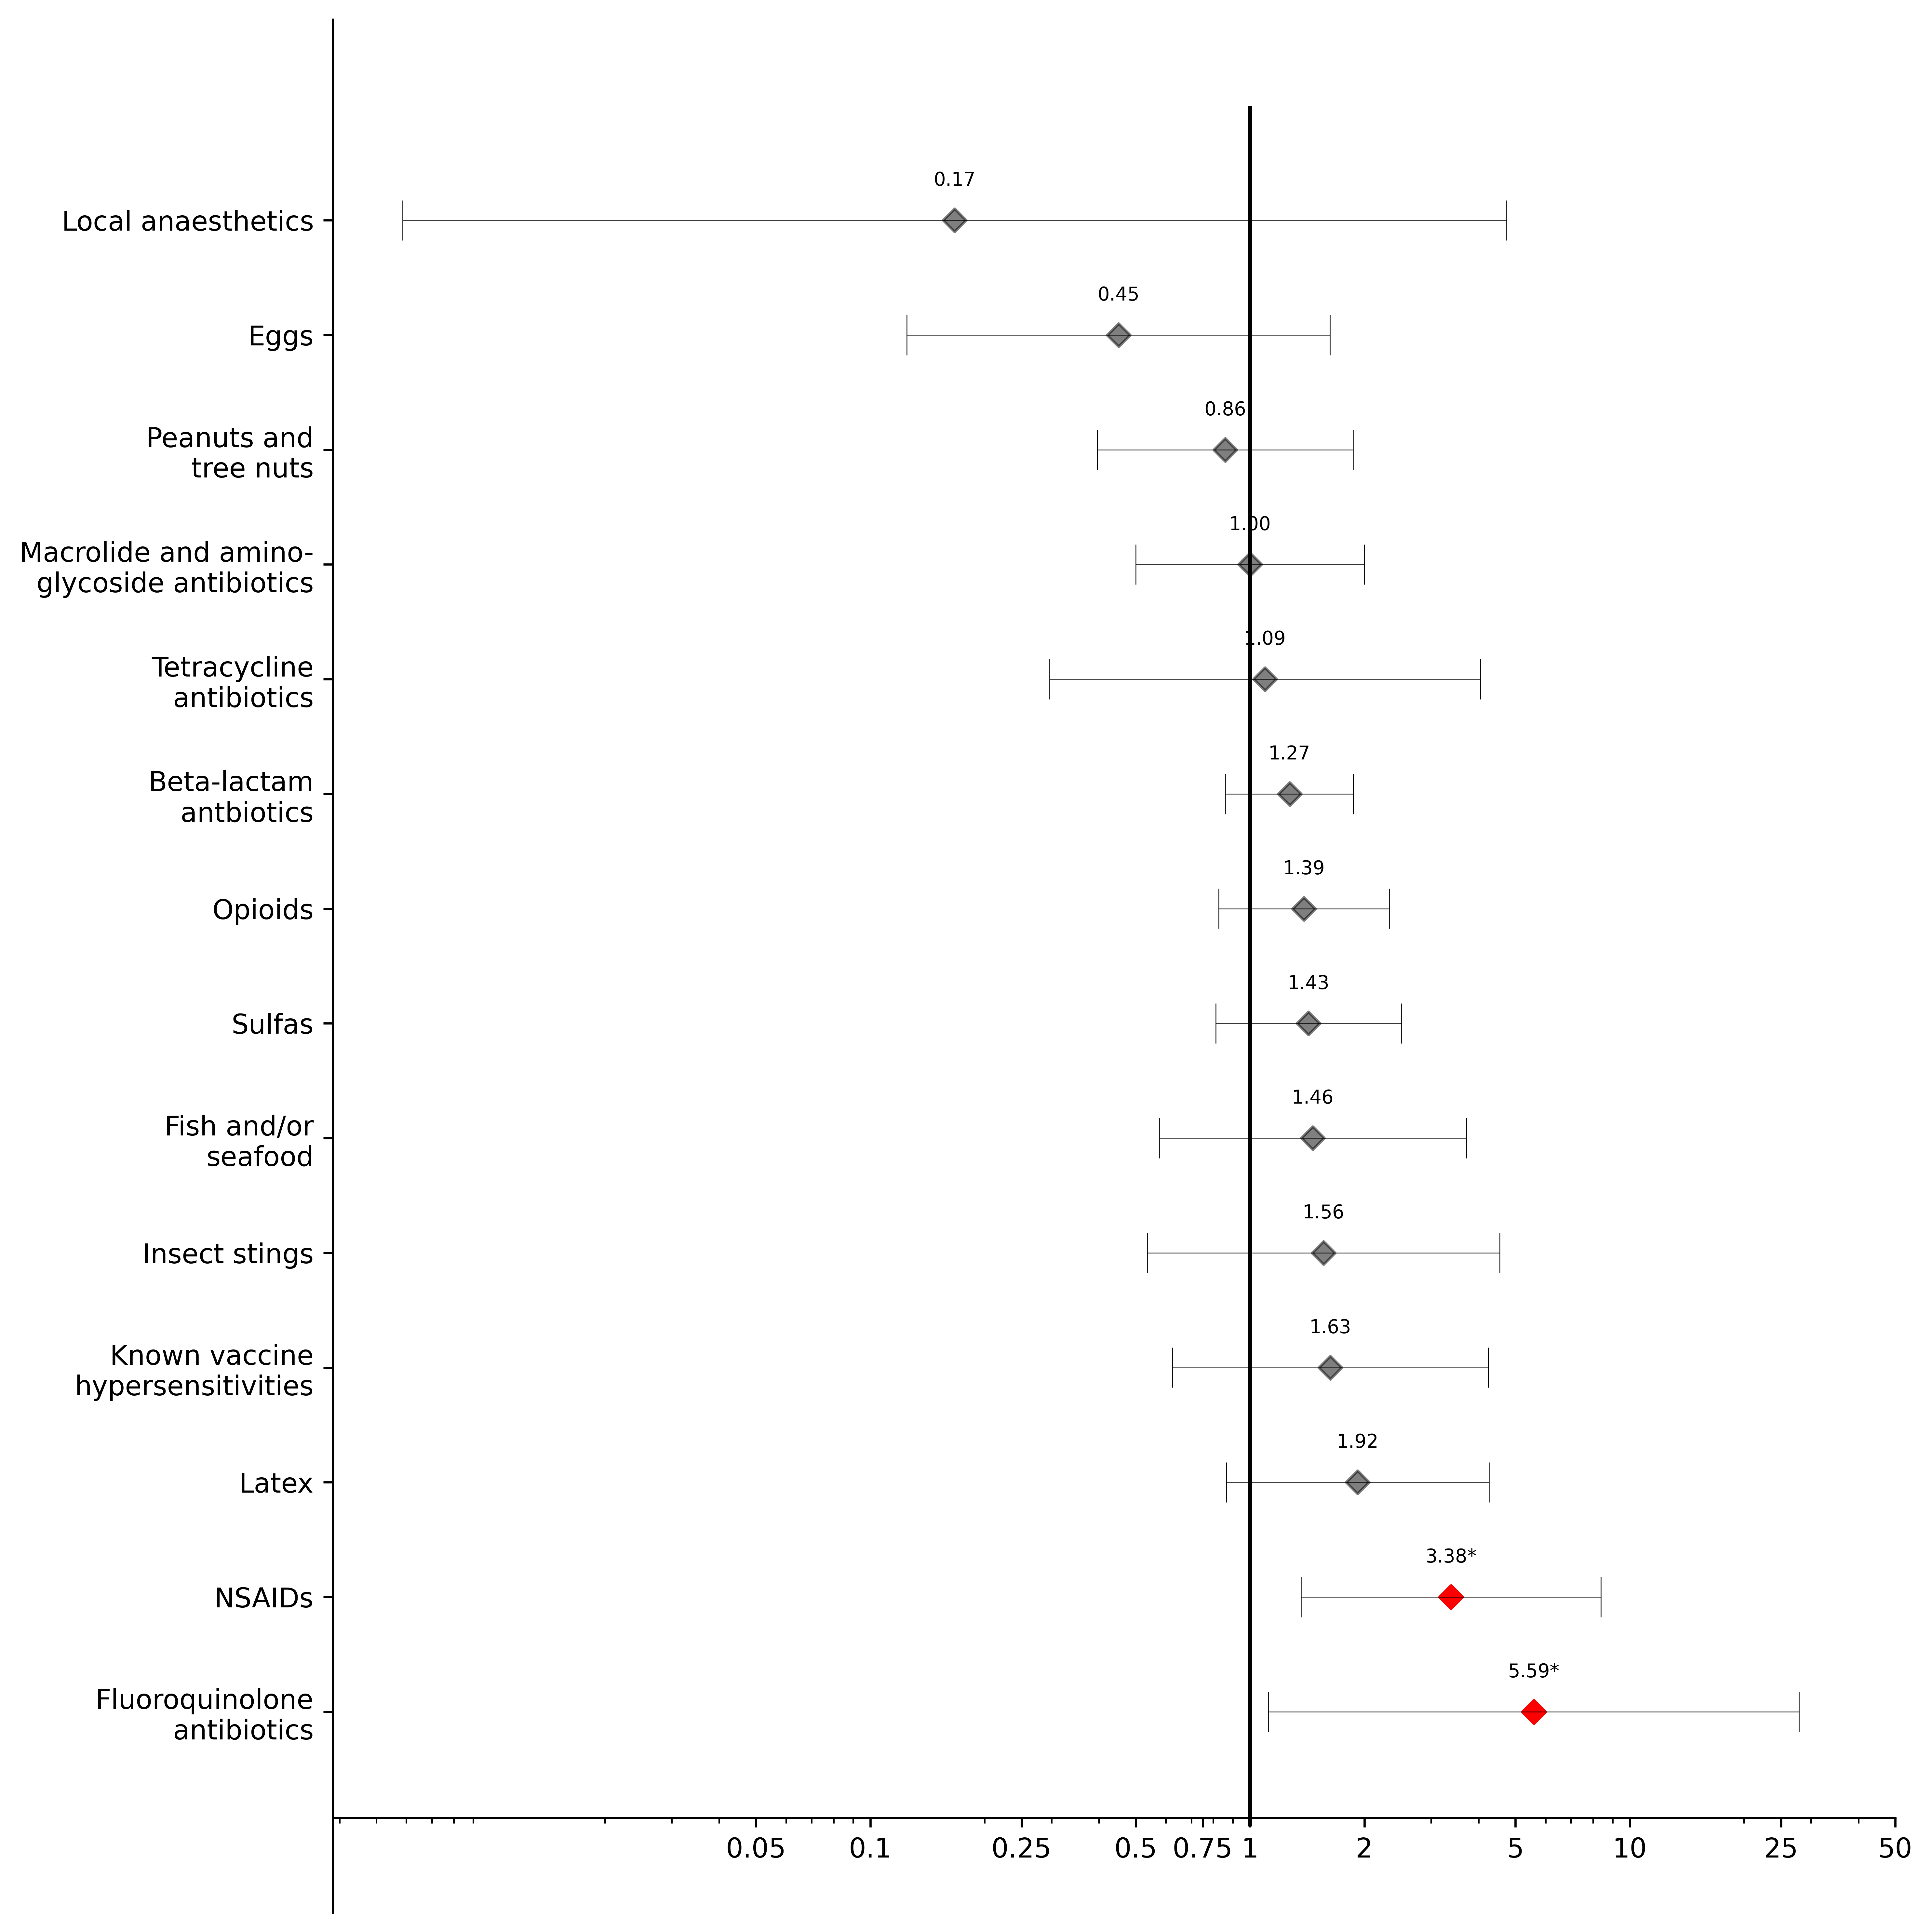

In [102]:
WHISKER:float = 0.175

fig, ax = plt.subplots(figsize=(10, 10), dpi=600)

odds_ratios_by_preexisting_allergy = odds_ratios_by_preexisting_allergy.sort_values("ROR", ascending=False)

ax.scatter(odds_ratios_by_preexisting_allergy.ROR, odds_ratios_by_preexisting_allergy.index, marker="D", color="k", alpha=0.5)
ax.scatter(odds_ratios_by_preexisting_allergy[odds_ratios_by_preexisting_allergy.p_value < 0.05].ROR, odds_ratios_by_preexisting_allergy[odds_ratios_by_preexisting_allergy.p_value < 0.05].index, marker="D", color="r", alpha=1.0)

ax.vlines(x=1, ymin=-1, ymax=len(odds_ratios_by_preexisting_allergy.index), colors="k")

for idx, val in enumerate(odds_ratios_by_preexisting_allergy.index):
    ax.hlines(y=idx, xmin=odds_ratios_by_preexisting_allergy.loc[val, "95CI_lower"], xmax=odds_ratios_by_preexisting_allergy.loc[val, "95CI_upper"], color="k", lw=0.3, alpha=0.8)
    pvalue_marker = "***" if odds_ratios_by_preexisting_allergy.loc[val, "p_value"] < 0.001 else ("**" if odds_ratios_by_preexisting_allergy.loc[val, "p_value"] < 0.005 else ("*" if odds_ratios_by_preexisting_allergy.loc[val, "p_value"] < 0.05 else ""))
    ax.text(y = idx + 0.3, x = odds_ratios_by_preexisting_allergy.loc[val, "ROR"], s = f"{odds_ratios_by_preexisting_allergy.loc[val, 'ROR']:.2f}{pvalue_marker}", horizontalalignment="center", fontsize="x-small")
    ax.vlines(x=odds_ratios_by_preexisting_allergy.loc[val, "95CI_lower"], ymin=idx-WHISKER, ymax=idx+WHISKER, color="k", lw=0.3)
    ax.vlines(x=odds_ratios_by_preexisting_allergy.loc[val, "95CI_upper"], ymin=idx-WHISKER, ymax=idx+WHISKER, color="k", lw=0.3)

ax.set_xscale("log")
#ax.set_xlim(4e-2, 2e1)

ax.spines.left.set_position(("axes", 0.0))
ax.spines.right.set_color("none")
ax.spines.bottom.set_position(("axes", 0.05))
ax.spines.top.set_color("none")
ax.xaxis.set_ticks_position("bottom")
ax.yaxis.set_ticks_position("left")

ax.set_xticks([0.05, 0.1, 0.25, 0.5, 0.75, 1, 2, 5, 10, 25, 50])
ax.set_xticklabels([0.05, 0.10, 0.25, 0.5, 0.75, 1, 2, 5, 10, 25, 50])

plt.tight_layout()
plt.savefig("../writeup/forest_plot_of_anaphylaxis_by_known_allergies.pdf")

plt.show()


